<a href="https://colab.research.google.com/github/Sadickachuli/Sound-Clustering/blob/main/MSA_Sound_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [ ]:
#Make allNecessary Imports
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import cdist


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### My first error

The first error I encountered was ***"TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'"* which means that plt.scatter() requires at least two arguments (x and y) but nothing was provided. This is a no-brainer haha. So what I did was create a function extract_features(file_path) which extracts Mel Spectrogram features, then converts them to decibels, and then takes the mean across the time axis which returns a feature vector.

After I extracted the features from all .wav files, I stored them in features_array.

Also I could have used the extracted features without converting to decibels but it would make the Mel spectrogram values have a larger range, hence making it less stable and with extreme values, the visualization will be even more heavily skewed compared to what I have here

In [ ]:

# Load the Data
unlabelled_data_path = "/content/drive/My Drive/unlabelled_sounds/"

# Function to extract Mel Spectrogram features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return np.mean(mel_spec_db, axis=1)  # The mean across time axis

#Extract Features from all the files
features = []
file_names = []

for file in os.listdir(unlabelled_data_path):
    if file.endswith(".wav"):
        file_path = os.path.join(unlabelled_data_path, file)
        feature = extract_features(file_path)
        features.append(feature)
        file_names.append(file)

features_array = np.array(features)  # Converting list to numpy array
print(f"Extracted features shape: {features_array.shape}")

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1567
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1410
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1446
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2014
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

Extracted features shape: (3011, 128)


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1381
  warnings.warn(


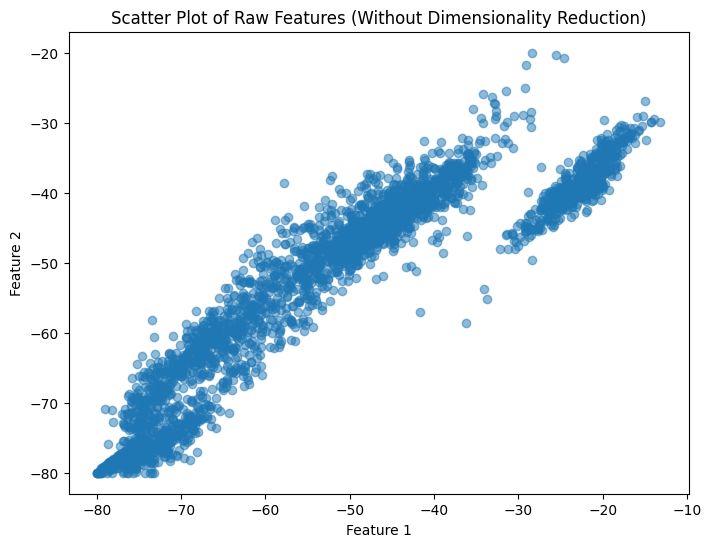

In [ ]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.5) # I added this to create a scatter plot of only the first two features in the dataset.
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()


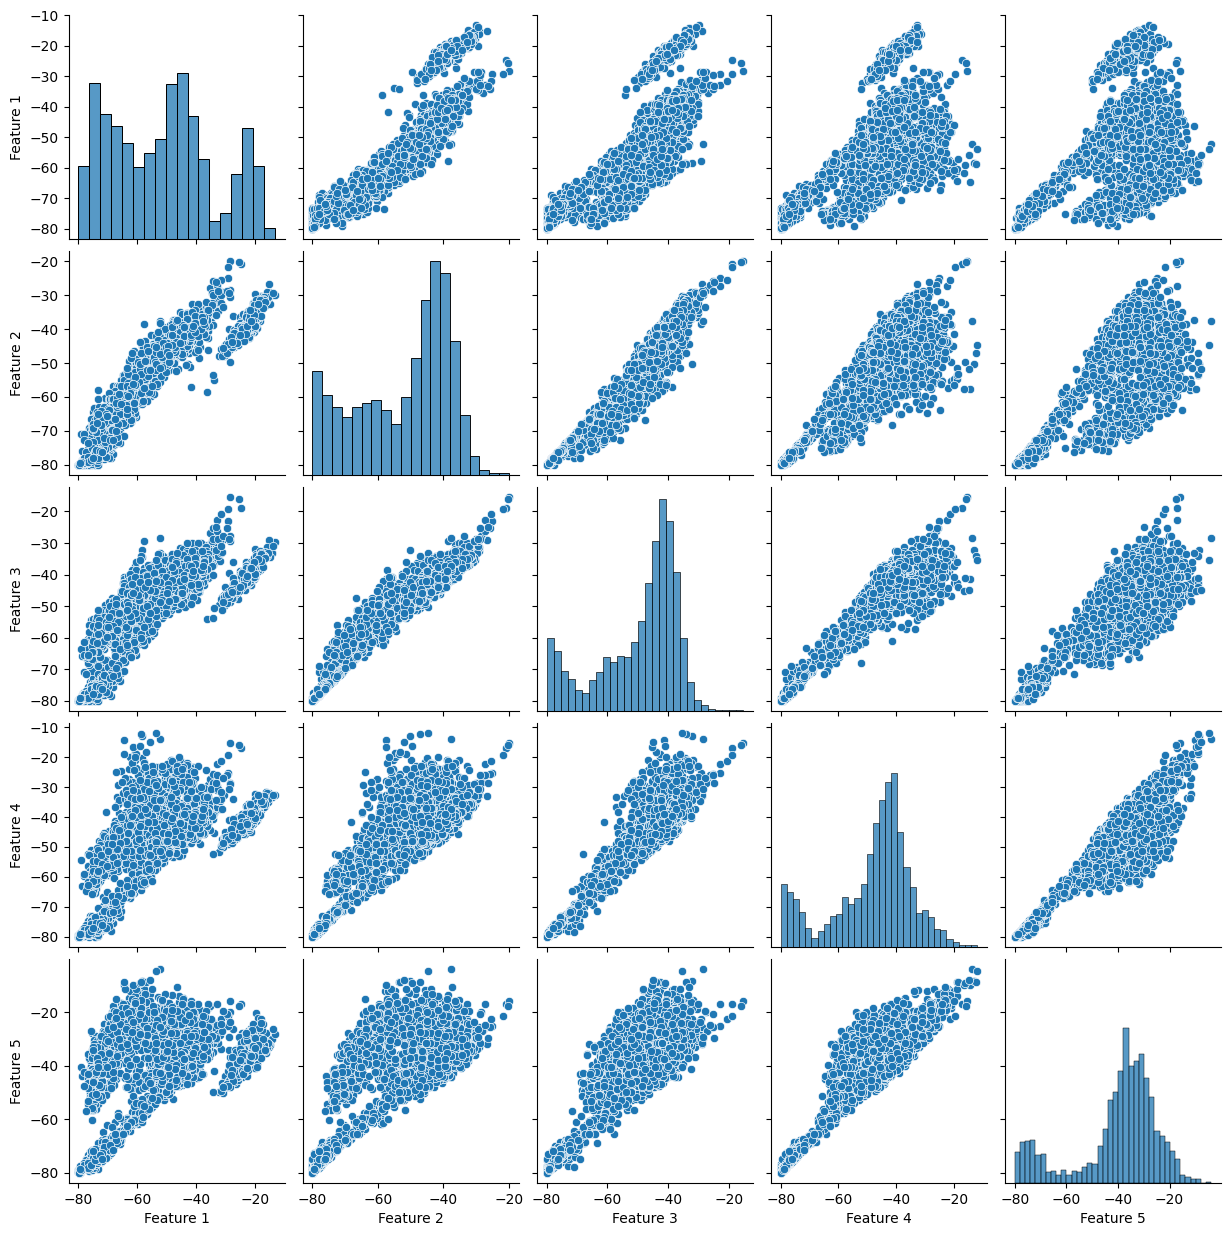

In [ ]:
# Convert to DataFrame for pairplot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i}" for i in range(1, 6)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

If we check our scatter plots above without dimensionality reduction, we can observe that,the features are highly correlated and this will definetely make it difficult for our clustering algorithms to clearly define meaningful and valid separations.This poses a big challenge. Also the distribution of points indicates that there are noise and redundancy in the feature space. So dimensionality reduction is important because it removes unneccessary noise and redundant features from the dataset and clear overlapping points in scatter plots and a provide a clear structure.

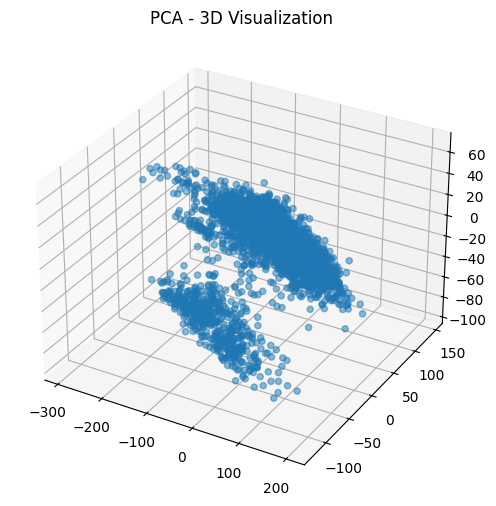

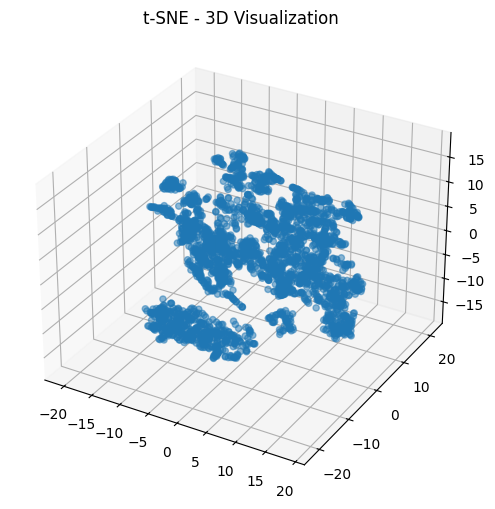

In [ ]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization goes here
# For PCA
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5)
ax.set_title("PCA - 3D Visualization")
plt.show()

# For t-SNE
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5)
ax.set_title("t-SNE - 3D Visualization")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

From my visualizations:

1. PCA plot:

With my PCA plot, we can see that the data points are kinda spread out in a clear and structured way, but when we check the separation between potential clusters we can see that they are not very well-defined.
What I mean is that the distribution looks way too linear, which depicts that the PCA captures large-scale variance but then agian does not really emphasize local structure or nonlinear relationships.

2. t-SNE plot:

The t-SNE plot on the other hand actually reveals more compact and properly-separated regions. This means that it is undoubtedly better at capturing the local structure of the data.
An important thing to also notice is that, it appears more scattered compared to the PCA distribution plot but t-SNE is actually very effective at preserving the distances between similar points which in turn leads to a much more better cluster formation.



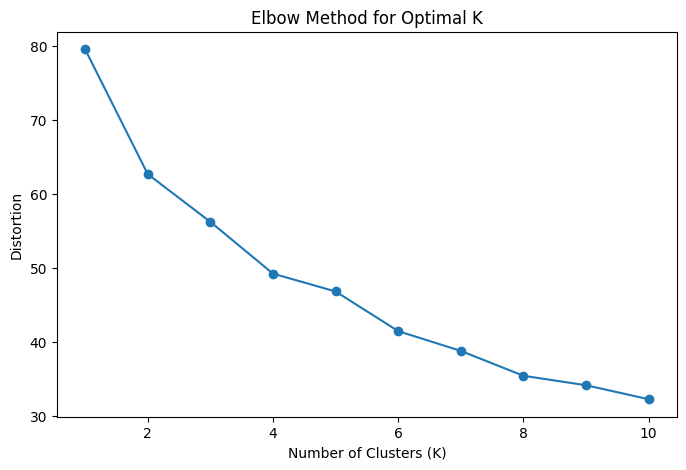

In [ ]:
# Optimize number of clusters using Elbow Method
distortions = [] # This will store the average distortion for each K value
K_range = range(1, 11)

for k in K_range: # This will loop through each K and fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    distortions.append(sum(np.min(cdist(features_pca, kmeans.cluster_centers_, "euclidean"), axis=1)) / features_pca.shape[0])

plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Distortion")
plt.title("Elbow Method for Optimal K")
plt.show()


From this I can see that the elbow starts at K=4

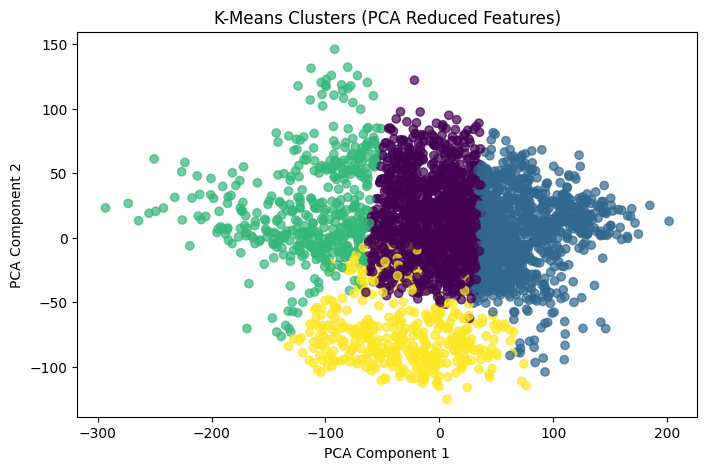

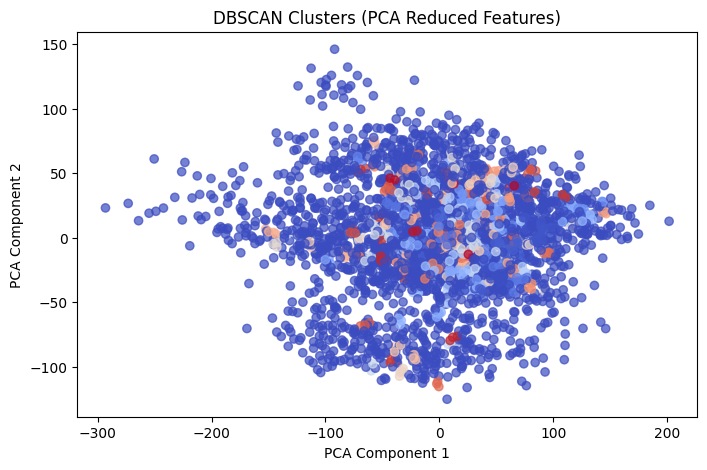

In [ ]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters (PCA Reduced Features)")
plt.show()
# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap="coolwarm", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clusters (PCA Reduced Features)")
plt.show()


In [ ]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.2608, Davies-Bouldin Index: 1.3188
DBSCAN - Silhouette Score: -0.4269, Davies-Bouldin Index: 1.6890


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

From the first plot, we can see how K-Means produced clear and well-organized clusters, whiles in the second plot it was difficult for DBSCAN to properly identify any clusters at all. This is due to the presence of noisy points which means it did not effectively separate meaningful groups.
Also k-means silhouette score indicates somewhat moderate clustering quality whiles the DBSCAN silhouette score is in the negatives showing how terrible it is

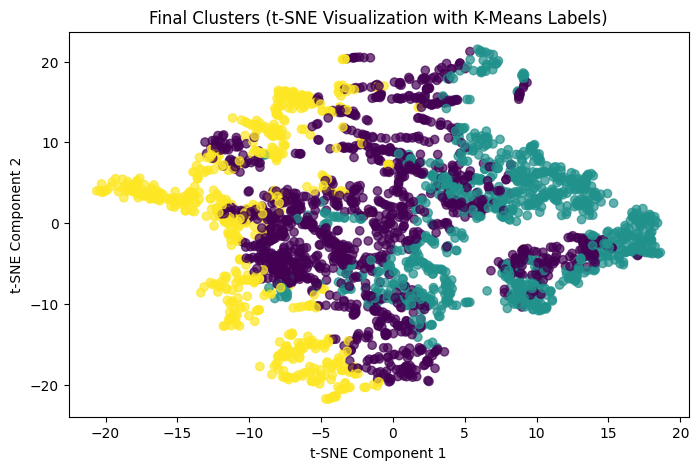

In [ ]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.

From what we have done so far, we can proudly say that dimensionality reduction has helped us in clustering. when we check the plots of our previous one without dimensionality reduction against the ones with dinmentionality reduction, we can see a huge increase in quality and noise reduction. we also saw a more distinct clusters which makes it way easier for algorithms to interprete.
- Justify why certain clustering methods worked better.

For this assigment, we can see from our plots above that K-means performs better than DBSCAN. I found out the reason why that is, is because K-means effectively created structured and balanced clusters specifically for this sound dataset(which has compact, well-separated clusters) due to its ability to assume spherical clusters of equal size.
The reason DBSCAN could not perform good is because it could not identify clear density-based clusters.
- Relate findings to real-world clustering challenges.

Having worked on many machine learning models and datasets, I know that most datasets have irrelevant and unneccessary features that provide noise and could degrade clustering performance. That being said, through this assignment, I found out that this type of sound dataset with it's type of noiswe can be improved with t-SNE for dimensionality reduction since it preserved important structures which led to a better clustering result. Also it can be seen that using either K-means or DBSCAN depends on the type of dataset we are working with. In our case we founf that K-means was the right clustering algorithm because it works better for well-separated clusters whiles DBSCAN is better for complex shapes